# Abstract
We will be applying a few Machine Learning models on the Telco Customer Churn dataset to predict the customers that will churn and later try to interpret these  models to provide Business with actionable insights.

We will be performing the following tasks:

1. Fit a linear model and interpret the regression coefficients

2. Fit a tree-based model and interpret the nodes

3.  Use Auto ml to find the best model

4. Run SHAP analysis on the models, interpret the SHAP values and compare them with the other model interpretability methods

## What is Model Interpretability?
* A machine learning algorithm’s interpretability refers to how easy it is for humans to understand the processes it uses to arrive at its outcomes.
* When using an algorithm’s outcomes to make high-stakes decisions, it’s important to know which features the model did and did not take into account.
* If a model isn’t highly interpretable, the business might not be legally permitted to use its insights to make changes to processes.

In [ ]:
#Install AutoML library - PyCaret
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 7.0 MB/s 
     |████████████████████████████████| 325 kB 30.6 MB/s 
     |████████████████████████████████| 6.8 MB 44.0 MB/s 
     |████████████████████████████████| 56 kB 1.7 MB/s 
     |████████████████████████████████| 3.3 MB 3.0 MB/s 
     |████████████████████████████████| 1.7 MB 38.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 141 kB 23.9 MB/s 
     |████████████████████████████████| 662 kB 58.7 MB/s 
     |████████████████████████████████| 25.8 MB 1.6 MB/s 
     |████████████████████████████████| 167 kB 80.8 MB/s 
     |████████████████████████████████| 1.3 MB 56.6 MB/s 
     |████████████████████████████████| 5.0 MB 56.6 MB/s 
     |████████████████████████████████| 

In [ ]:
#Installing SHAP and other required libraries
!pip install shap
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 229 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.8 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

# Importing Packages
import seaborn as sns
import math 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 
from scipy.stats import norm, skew #for some statistics
from scipy import stats

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv


In [ ]:
#Reading the data
telecom_cust=pd.read_csv("/content/Telco-Customer-Churn.csv")

### Dataset - Telco customer Churn
Each row represents a customer; 
Each column contains customer’s attributes such as demographics, services, the associated cost and the target label 'Churn'.

### Problem Statement
**Binary Classification**: Predict is the customer is going to leave usi.e. Yes or No.

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary
resumetable(telecom_cust)

Dataset Shape: (7043, 21)


,Name,dtypes,Missing,Uniques,Sample Value,Entropy
0,customerID,object,0,7043,7590-VHVEG,3.85
1,gender,object,0,2,Female,0.30
2,SeniorCitizen,int64,0,2,0,0.19
3,Partner,object,0,2,Yes,0.30
4,Dependents,object,0,2,No,0.27
5,tenure,int64,0,73,1,1.78
6,PhoneService,object,0,2,No,0.14
7,MultipleLines,object,0,3,No phone service,0.41
8,InternetService,object,0,3,DSL,0.46
9,OnlineSecurity,object,0,3,No,0.45


**Entropy** is defined as the randomness or measuring the disorder of the information being processed.

**Actions required for data preparation:**

* Converting Total Charges to a numerical data type.
* Removing customer IDs from the data set as it is unique to every record and we therefore won't use it as a predictor variable.
* Encoding categorical features.

In [ ]:
#Dropping customer ID
cust = telecom_cust.iloc[:,1:].copy()

#Label Encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
cust['Partner'] = le.fit_transform(cust.Partner.values)
cust['Dependents'] = le.fit_transform(cust.Dependents.values)
cust['gender'] = le.fit_transform(cust.gender.values)
cust['PhoneService'] = le.fit_transform(cust.PhoneService.values)
cust['PaperlessBilling'] = le.fit_transform(cust.PaperlessBilling.values)

#Coverting totalCharges to numerical data type.
cust.TotalCharges = pd.to_numeric(cust.TotalCharges, errors='coerce')

**Action :**
Checking for missing values after changing the data type.

In [ ]:
cust.TotalCharges.isna().sum()

11

In [ ]:
cust[cust.TotalCharges.isna()][['tenure','MonthlyCharges','TotalCharges','Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


**Observation**: All the new customers(i.e. tenure=0 months) have no total charges data available.

**Action**: We would drop these rows here as all of them have been in the system for less than a month and Customers are marked as churned if they have left the system in the last one month.

In [ ]:
#Removing missing values
cust.dropna(inplace = True)

In [ ]:
cust['Churn'].replace(to_replace='Yes', value=1, inplace=True)
cust['Churn'].replace(to_replace='No',  value=0, inplace=True)

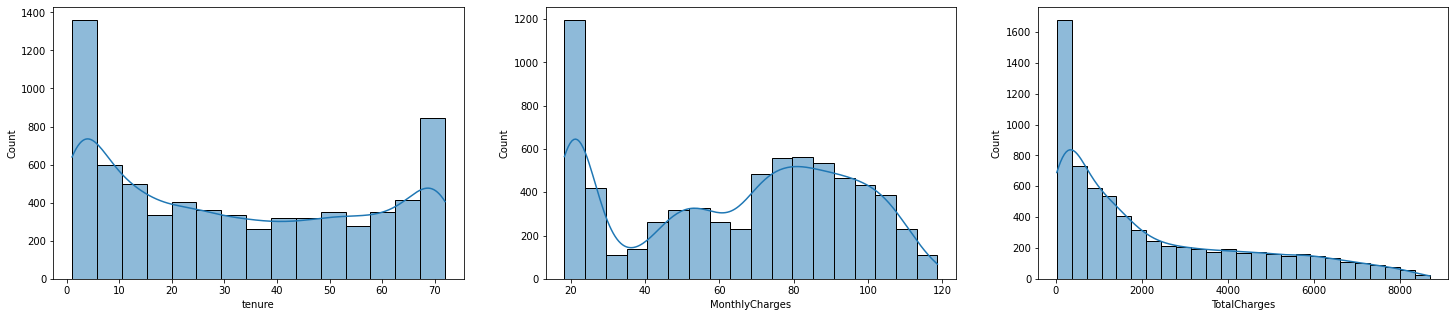

In [ ]:
plot , ax = plt.subplots( 1,3 , figsize = (25 , 5))
g = sns.histplot(cust['tenure'] , kde = True , ax = ax[0])
g = sns.histplot(cust['MonthlyCharges'] , kde = True , ax = ax[1])
g = sns.histplot(cust['TotalCharges'] , kde = True , ax = ax[2])

**Observation :**

These numerical variables are not following a normal distribution. These distributions indicate there are different data distributions present in population data with separate and independent peaks.

**Action :**

**Data scaling**, As most of the algorithms assume the data to be normally (Gaussian) distributed we **Normalize** these features.

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
cust_dummies=pd.get_dummies(cust)
cust_dummies['tenure'] = mms.fit_transform(cust_dummies[['tenure']])
cust_dummies['MonthlyCharges'] = mms.fit_transform(cust_dummies[['MonthlyCharges']])
cust_dummies['TotalCharges'] = mms.fit_transform(cust_dummies[['TotalCharges']])

In [ ]:
pred=cust_dummies.copy()
Churn=pred['Churn']
pred.drop(columns='Churn',inplace=True)

In [ ]:
#Setting the target label and predictor variables
y = Churn.values
X = pred.copy()

# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Logistic Regression

In [ ]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
result = log.fit(X_train, y_train)

# Print the prediction accuracy
from sklearn import metrics
y_pred = log.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred))

0.7912400455062572


### Intercept

In [ ]:
print(log.intercept_)

[-0.94333933]


**Observation :** 
* Since the intercept has a negative sign: then the probability of having the outcome will be < 0.5.
* We can derive the Probability from the Log odss using the formula e^(B0)/(1+e^(B0))
* If we just use the Y-intercept, i.e. We do not pass any feature then 

**The probability of a customer churning is 28.09%**

### Coefficients

In [ ]:
coef=pd.DataFrame(zip(X_train.columns, np.transpose(log.coef_[0])), columns=['features', 'coef']).sort_values(by=['coef'])
coef.head(50)

,features,coef
4,tenure,-3.266933
35,Contract_Two year,-0.639898
12,InternetService_DSL,-0.410587
3,Dependents,-0.248225
9,MultipleLines_No,-0.183541
7,MonthlyCharges,-0.156845
5,PhoneService,-0.156068
17,OnlineSecurity_Yes,-0.154891
37,PaymentMethod_Credit card (automatic),-0.149381
26,TechSupport_Yes,-0.125329


**Observation :** Negative weights indicate an inverse correlation whereas positive correlation with the Target label - Churn.
* Tenure is the most significant feature and inversly corelated to churn.
* Customers having Month-to-month contract are more likely to Churn compared to customers having two year contract.


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(max_depth=7)

# Train Decision Tree Classifer
dt = dt.fit(X_train,y_train)

#Predict for test dataset
y_pred = dt.predict(X_test)

# Print the prediction accuracy
print (metrics.accuracy_score(y_test, y_pred))

0.7758816837315131


### Feature Importance - Decision Tree

In [ ]:
importance = dt.feature_importances_

In [ ]:
#Creating a dict of feature and their importance
feature_importance = {}
for i, feature in enumerate(X_train.columns):
    feature_importance[feature] = round(importance[i], 3)

feat_df = pd.DataFrame({'Feature':feature_importance.keys(),'Importance':feature_importance.values()})

In [ ]:
feat_df.sort_values(by='Importance',ascending=False).head(10)

,Feature,Importance
33,Contract_Month-to-month,0.516
4,tenure,0.170
13,InternetService_Fiber optic,0.160
8,TotalCharges,0.047
7,MonthlyCharges,0.037
15,OnlineSecurity_No,0.024
38,PaymentMethod_Electronic check,0.021
5,PhoneService,0.009
1,SeniorCitizen,0.008
35,Contract_Two year,0.004


### Interpreting the Nodes of Decision Tree

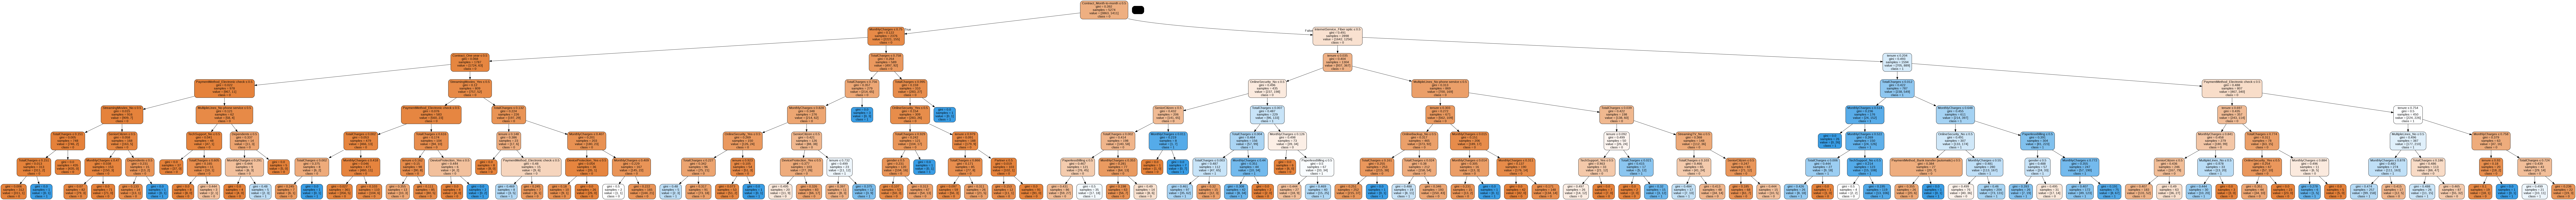

In [ ]:
from six import StringIO
from sklearn.tree import export_graphviz 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = pred.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Observation :**

* Each node has an attribute (feature) that acts as the catalyst for further splitting in the downward direction. eg Here it starts with if the customer is using electronic check as payment method.
* Gini Index is a score that evaluates how accurate a split is among the classified groups.
* Here we have limited the depth of the decision tree to 5 splits for simple interpretation.

# AutoML - PyCaret Library to select and tune the best Model

In [ ]:
# importing classification
from pycaret.classification import *

### Setting up the classifier

In [ ]:
# Setting up
clf1 = setup(data = cust, 
             target = 'Churn',
             normalize=True,
             normalize_method='minmax',
             remove_multicollinearity=True,
             fold=5,
             fix_imbalance=True,
             silent = True)

,Description,Value
0,session_id,7527
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(7032, 20)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Churn',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('dummy', Dummify(target='Churn')),
                ('fix_perfect', Remove_100(target='Churn')),
                ('clean_names', Clean_Colum_Names()),
       

### Model Comparison & Evaluation

In [ ]:
best_model=compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7588,0.8444,0.7959,0.5240,0.6319,0.4637,0.4862,0.862
ada,Ada Boost Classifier,0.7781,0.8469,0.7295,0.5563,0.6309,0.4765,0.4857,0.404
ridge,Ridge Classifier,0.7503,0.0000,0.7936,0.5130,0.6231,0.4491,0.4730,0.094
lda,Linear Discriminant Analysis,0.7501,0.8419,0.7928,0.5127,0.6227,0.4485,0.4724,0.116
gbc,Gradient Boosting Classifier,0.7865,0.8434,0.6662,0.5779,0.6185,0.4714,0.4740,1.102
nb,Naive Bayes,0.7397,0.8275,0.7772,0.5000,0.6083,0.4270,0.4504,0.096
svm,SVM - Linear Kernel,0.7509,0.0000,0.7332,0.5282,0.6041,0.4329,0.4540,0.128
lightgbm,Light Gradient Boosting Machine,0.7893,0.8341,0.5919,0.5963,0.5934,0.4514,0.4518,0.802
rf,Random Forest Classifier,0.7790,0.8212,0.5848,0.5739,0.5790,0.4292,0.4295,0.944
knn,K Neighbors Classifier,0.6877,0.7619,0.7240,0.4390,0.5466,0.3296,0.3537,0.594


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7527, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


**Observation**:

* Logistic Regression has the highest F1 score and MCC in predicting the churn customers.
* It is followed by Ada Boost Classifier and Ridge classifier.

### Hyperparameter Tuning

In [ ]:
# tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7624,0.8365,0.8047,0.5282,0.6378,0.4721,0.4953
1,0.7533,0.8477,0.7852,0.5167,0.6233,0.4512,0.4731
2,0.7815,0.8576,0.8118,0.5535,0.6582,0.5059,0.5260
3,0.7490,0.8416,0.7773,0.5116,0.6171,0.4419,0.4633
4,0.7470,0.8387,0.8008,0.5087,0.6222,0.4458,0.4718
Mean,0.7586,0.8444,0.7959,0.5237,0.6317,0.4634,0.4859
Std,0.0126,0.0076,0.0127,0.0163,0.0149,0.0237,0.0227


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:LogisticRegression(C=1.015, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7527, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
tuned_model.predict

<bound method LinearClassifierMixin.predict of LogisticRegression(C=1.015, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7527, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier # Import Gradient Boosting Classifier

# # Create Decision Tree classifer object
# best = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
#                            learning_rate=0.05, loss='deviance', max_depth=7,
#                            max_features='log2', max_leaf_nodes=None,
#                            min_impurity_decrease=0.02, min_impurity_split=None,
#                            min_samples_leaf=4, min_samples_split=2,
#                            min_weight_fraction_leaf=0.0, n_estimators=230,
#                            n_iter_no_change=None, presort='deprecated',
#                            random_state=8292, subsample=0.35, tol=0.0001,
#                            validation_fraction=0.1, verbose=0,
#                            warm_start=False)

# # Train Decision Tree Classifer
# best = best.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = best.predict(X_test)

# # Print the prediction accuracy
# print (metrics.accuracy_score(y_test, y_pred))

0.7821387940841866


In [ ]:
#Installing support library
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 8.2 MB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1


# Model Interpretability using SHAP

* SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

* The Shapley value is a method used in game theory that involves fairly distributing both gains and costs to actors working in a coalition.

* Since each actor contributes differently to the coalition, the Shapley value makes sure that each actor gets a fair share depending on how much they contribute.



In [ ]:
import shap

In [ ]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

### Interpret Logistic Regression Model using SHAP

In [ ]:
# compute the SHAP values for the linear model
explainer_log = shap.Explainer(log.predict, X100)
shap_values_log = explainer_log(X_train)

Permutation explainer: 5275it [05:02, 17.01it/s]


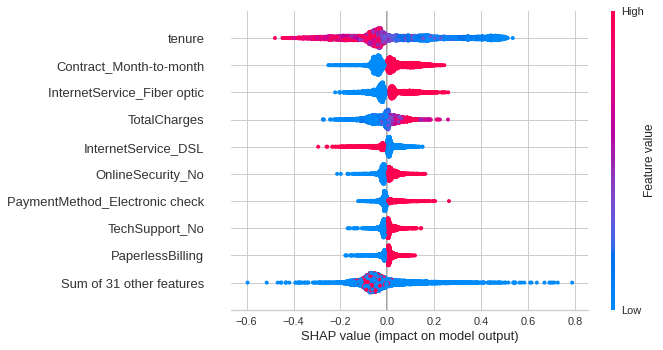

In [ ]:
shap.plots.beeswarm(shap_values_log)

**In a Beeswarm plot**, 
* For each variable, every instance of the dataset appears as it's own point, the points are distributed across the x-axis according to their SHAP values.
* The input variables are ranked from the top in accordance to their mean SHAP values.

Here Tenure and Monthly Contract are the top features, 
* With increase in the tenure of a customer, the probability of churn reduces 
* If a customer opts for monthly contract then the probability for Churn increases.

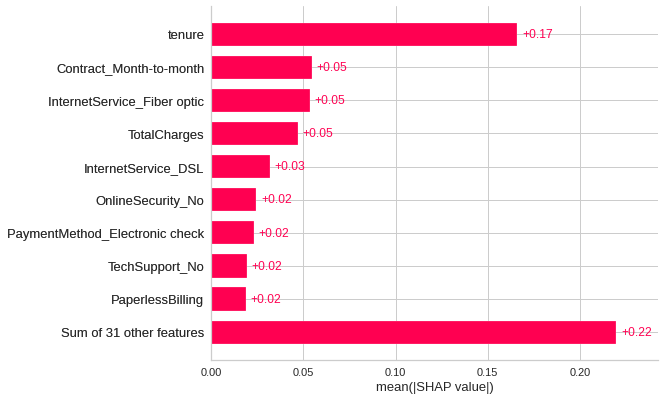

In [ ]:
shap.plots.bar(shap_values_log)

Displaying the average SHAP values of each individual feature.
**Observation:**
* Here we see that tenure of the Customer is the most influential variable, contributing on average 0.17 to predict Churn Customers.

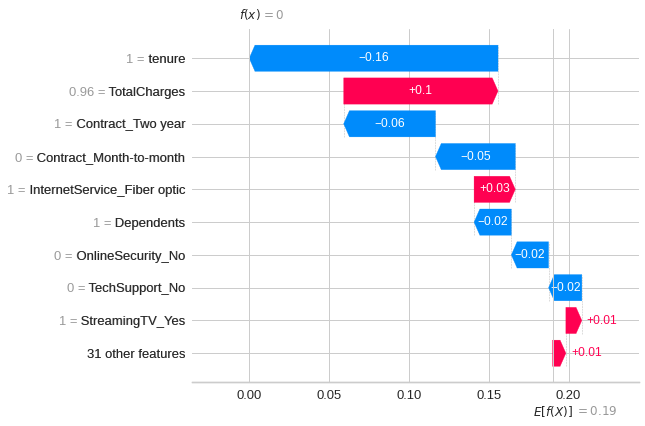

In [74]:
shap.plots.waterfall(shap_values_log[10], max_display=10)

Here, we plot an example and see how the predictor variables impact the probability of a customer to churn.
* Example, here scaled tenure=1(maximum) reduces the log odds of a customer churning by 0.16 
* Scaled TotalCharges = 0.96(higher end) increases the log odds of Churn by 0.

Here we predict that the Customer won't churn based on the predictors

### Partial Dependence Plot

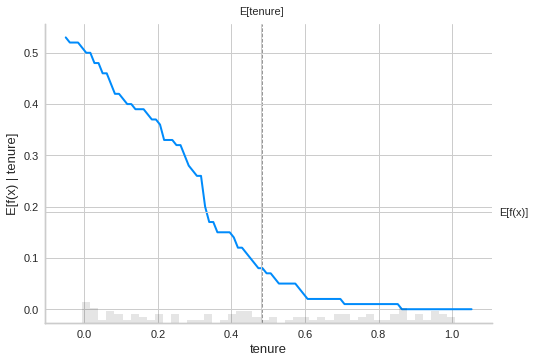

In [ ]:
shap.partial_dependence_plot(
    "tenure", log.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Here, we can observe that there is a steep decrease in the probability of Customer Churning in the initial time period and later the probability flattens out.

### Interpreting Decision Tree Model using SHAP

In [77]:
# compute the SHAP values for the linear model
explainer_dt = shap.Explainer(dt.predict, X100)
shap_values_dt = explainer_dt(X_train)

Permutation explainer: 5275it [03:26, 24.99it/s]                          


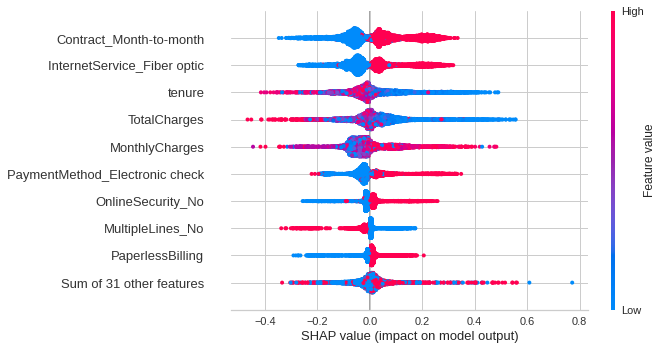

In [78]:
shap.plots.beeswarm(shap_values_dt)

Here Monthly Contract and Fiber Optic opted as InternetService are the top features, 
* If a customer opts for monthly contract then the probability for Churn increases
* If a customer uses Fiber Optic as an Internet service, they are more likely to Churn

Note: Here, we can see that with increase in Total Charges, the probability of a Customer churning reduces which is completely contrary to the observation we made for the Logistic Regression Model.
We would stick with our observation for the Logistic Regression Model as it makes logically more sense and is also outperforming the decision tree.

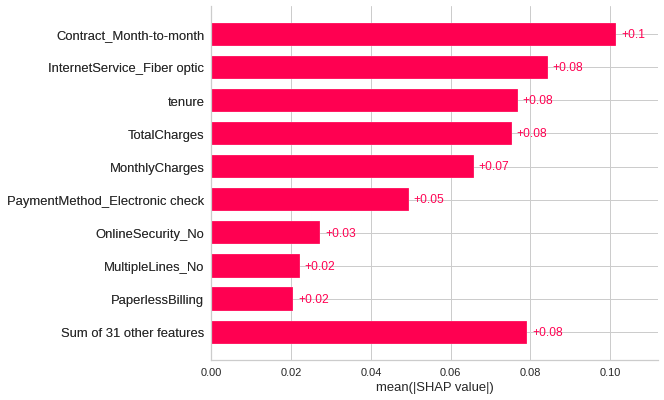

In [79]:
shap.plots.bar(shap_values_dt)

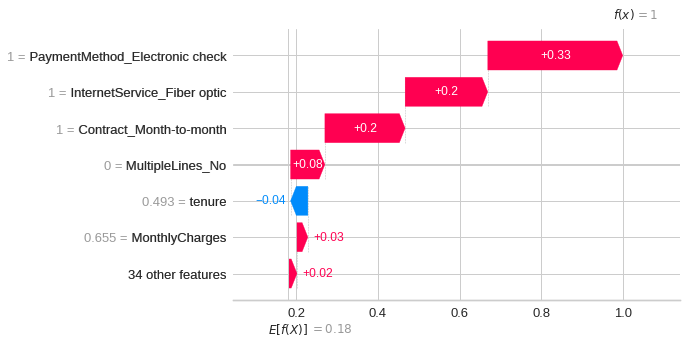

In [80]:
shap.plots.waterfall(shap_values_dt[sample_ind], max_display=7)

Here as we are using Electronic Check as Payment Method, the log odds of Customer Churning is increased by 0.33.

# Conclusion:

* We applied a Logistic Regression and Decision Tree Model and tried to interpret their co-efficients and nodes respectively.
* We use an AutoML Library to determine the best model.
* We use the SHAP library to determine the impact of features on predicting whether a customer will churn or not.
* Unlike other model importance methods, SHAP values identify the individual impact of features at a global level.

# License

**References**
https://pycaret.readthedocs.io/en/stable/api/classification.html

Copyright (c) 2022 chakraborty-arnab

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.